In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/My Drive/HSE_DL_2021/08_week

/content/gdrive/My Drive/HSE_DL_2021/08_week


# Что видит свёрточная сетка? 

Есть несколько способов попытаться понять что именно видит свёрточная сетка. О них и поговрим. Возьмём какую-нибудь предобученную сетку. Например, Alexnet, обученную на Imagenet 

## Визуализация промежуточных активаций.

Визуализация промежуточных активаций заключается в отображение карт признаков (feature maps), которые выводятся разными сверточными и объединяющими слоями в ответ на входные данные. Позволяет понять, какие патерны хочет найти сеть, как входные данные разлагаются на разные фильтры, сигналы в процессе обучения.

In [1]:
import torch
import torchvision

model = torchvision.models.alexnet(pretrained=True)

print(model)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Тут у нас будет загрузка картинки кота - она не использовалалась при обучении. 

In [ ]:
from torchvision import transforms
from PIL import Image


img_path = 'images/cat.1700.jpg'
img_init = Image.open(img_path)

# Помним, что предобученные модели в PyTorch обучались на картинках формата 224x224
print('before resize:', img_init.size)
img = img_init.resize((224, 224))
print('after resize:', img.size, '\n')

# Конвертируем `PIL.Image` к `torch.tensor`
transfs = transforms.Compose([torchvision.transforms.ToTensor()#,
                            #   torchvision.transforms.Normalize(
                            #       mean=[0.485, 0.456, 0.406],
                            #       std=[0.229, 0.224, 0.225])
                              ])
img_tensor = transfs(img)

# Добавим размероность батча
img_tensor = img_tensor[None]

print(img_tensor.shape)

before resize: (324, 333)
after resize: (224, 224) 

torch.Size([1, 3, 224, 224])


In [ ]:
img_tensor.dtype

torch.float32

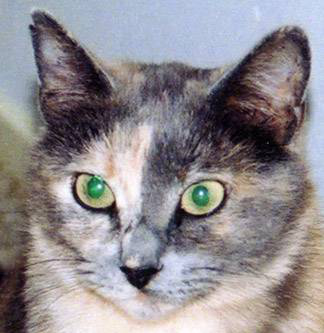

In [ ]:
img_init

Посмотрим на нашу картинку, на ее исходный формат

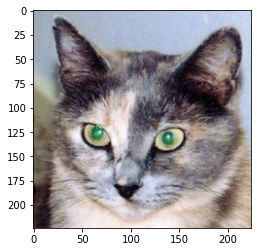

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.imshow(img_tensor[0].permute(1, 2, 0));

Для извлечения карт признаков, подлежащих визуализации, создадим модель PyTorch, которая принимает изображения и выводит активации всех сверточных и объединяющих слоев. Модель отображает заданные входные данные в заданные выходные данные.

In [ ]:
len(model.features)

13

In [ ]:
# Извлекаем слои features
with torch.no_grad():
    layer_outputs = [model.features[:1+i](img_tensor) for i in range(len(model.features))]

In [ ]:
len(layer_outputs)

13

Для примера, посмотрим, что у нас ищет первая активация

In [ ]:
first_layer_activation = layer_outputs[0]
print(first_layer_activation.shape)

torch.Size([1, 64, 55, 55])


Это карта признаков 55*55 с 64 каналами. И да, они каждый раз разные, прелесть и недостаток нейронных сетей.

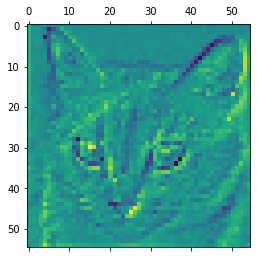

In [ ]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, 0, :, :], cmap='viridis');

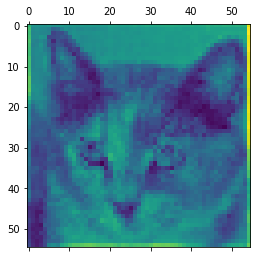

In [ ]:
# посмотрим более глубокие каналы

plt.matshow(first_layer_activation[0, 53, :, :], cmap='viridis');

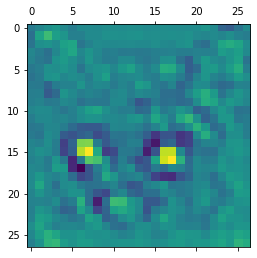

In [ ]:
second_layer_activation = layer_outputs[3]
plt.matshow(second_layer_activation[0, 0, :, :], cmap='viridis');

По сути видим, нахождение контуров именно кота. Чтож, давайте посмотрим на все визуализации сразу, на все наши выходные активации.

In [ ]:
import numpy as np

layer_names = ['Conv2d_1', 'ReLU_1', 'MaxPool_1', 
               'Conv2d_2', 'ReLU_2', 'MaxPool_2', 
               'Conv2d_3', 'ReLU_3', 
               'Conv2d_4', 'ReLU_4', 
               'Conv2d_5', 'ReLU_5', 'MaxPool_5']

images_per_row = 16

# функция для отображения всего и вся
i = 0
for layer_name, layer_activation in zip(layer_names, layer_outputs):
    # тут у нас количество фичей входящих сетку
    n_features = layer_activation.shape[1]

    # Карта признаков имеет следующую разнмерность (1, n_features, size, size)
    size = layer_activation.shape[2]

    # Переводим активационные каналы в матрицу
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # Вывод каждого в большую горизонтальную сеть
    j = 0
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             col * images_per_row + row,
                                             :, :]
            # Обработка картинки, для приемлемой визуализации
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).numpy().astype('uint8')

            # вывод значений пустого feature map (2-ая картинка ReLU_1)
            if i == 1 and j == 1:
                print(f'All values in channel_image are zero: {not np.any(channel_image)}')
                print(channel_image)

            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

            j += 1

    # Отображаем полученную сетку из картинок
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis');

    i += 1

Output hidden; open in https://colab.research.google.com to view.

Несколько итоговых закономерностей:

* Первый слой действует как коллекция разных детекторов контуров. На этом этапе активация сохраняет почти всю информацию, имеющуюся в исходном изображении
* по мере подъема вверх по слоям, активации становятся все более абстрактными, а их визуальная интерпретация все более сложной. Они начинают кодировать выскоуровневые понятия, такие как "кошачье ухо" или "кошачий глаз". Высокоуровневые представления несут все меньше информации об исходном изображении и все большее о классе.
* Разреженность активаций растет с глубиной слоя. Все больше фильтров остается пустыми, что значит, что нет маски, попадающий в сеть.

Мы только что показали очень важную универсальную характеристику представлений, изучаемых глубокими нейронными сетями: особенности, извлеченные слоем, становятся все более абстрактными с глубиной слоя. Активация верхних слоев несет все меньше и меньше информации о конкретном изображении, и все больше и больше информации о цели (в нашем случае, класс изображения: кошка или собака). Глубокая нейронная сеть эффективно действует как конвейер перегонки информации, в котором исходные данные поступают (в нашем случае, изображения RBG) и многократно преобразуются, так что ненужная информация отфильтровывается (например, конкретный визуальный вид изображения), а полезная информация увеличивается и уточняется (например, класс изображения).

Это аналогично тому, как люди и животные воспринимают мир: наблюдая за сценой в течение нескольких секунд, человек может вспомнить, какие абстрактные объекты присутствовали в ней (например, велосипед, дерево), но не может вспомнить конкретный внешний вид этих объектов. На самом деле, если вы попытаетесь нарисовать универсальный велосипед прямо сейчас, скорее всего, вы не сможете получить его даже отдаленно правильно, даже если вы видели тысячи велосипедов в своей жизни. Попробуйте прямо сейчас: этот эффект абсолютно реален. Ваш мозг научился полностью абстрагировать свой визуальный ввод, трансформировать его в визуальные концепции высокого уровня, полностью отфильтровывая ненужные визуальные детали, что чрезвычайно затрудняет запоминание того, как на самом деле выглядят окружающие нас вещи.

## Визуализация фильтров сверточных сетей


Другой простой способ исследовать фильтры, полученной сетью, - отобразить визуальный шаблон, за который отвечает каждый фильтр. Это можно сделать следюущим методом: методом градиентного восхождения в пространство входов (__gradient ascent in input space__). Выполняем градиентный спуск до значения входного изображения сверточной нейронной сети, максимизируя отлик конкретного фильтра, начав с пустого изображения. В результате получаем версию входного изображения, для которого отклик данного фильтра был максимален.

Задача решается просто-конструируем функцию потерь, которая максимизирует значение данного фильтра в данном сверточном слое и обучаемся. Для пробы-возьмем VGG16 обученный на Imagenet.

Альтернативное объяснение, котрое показалось мне более понятным:\
*Our process is simple: we will create input images that maximize the activation of specific filters in a target layer (picked somewhere in the middle of the model). Such images represent a visualization of the pattern that the filter responds to.*\
Взято [отсюда](https://keras.io/examples/vision/visualizing_what_convnets_learn/)

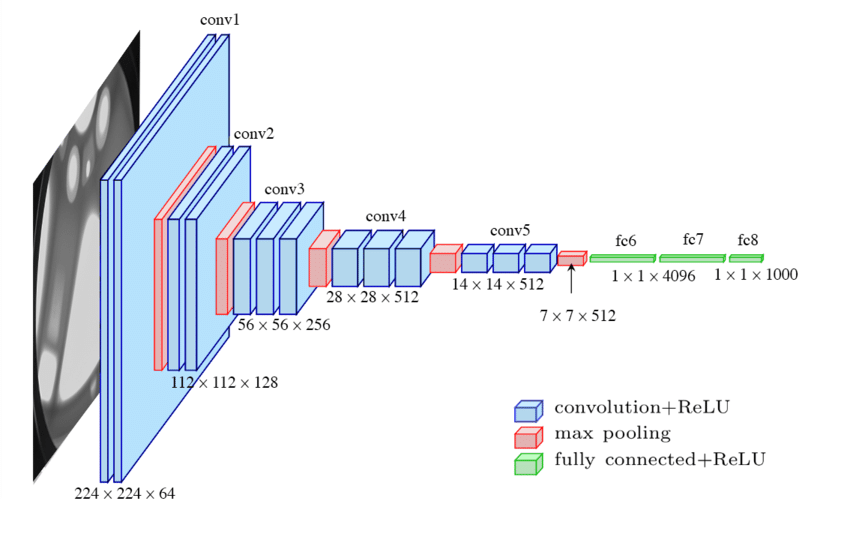

In [ ]:
display.Image('images/VGG16.png', retina=False)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

Для реализации нам нужен градиент потерь относительно входа модели. Для этого возьмем метод 
`backward` из PyTorch.

In [3]:
layer_num = 10

model = torchvision.models.vgg16(pretrained=True)
print(model.features[layer_num])

x = np.random.random((1, 3, 224, 224)) #* 20 + 128
input_img_data = torch.tensor(x, dtype=torch.float32, requires_grad=True)

filter_index = 0

output = model.features[:layer_num+1](input_img_data)  # 1 x 256 x H x W
output = output[:, filter_index, :, :]
loss = output.mean()
loss.backward()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
model = torchvision.models.vgg16(pretrained=True)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Иногда можно использовать неочевидный трюк, для ускорения схождения. Делим тензор на его L2 норму, это гарантирует, что величина обновлений всегда будет находится в одном диапозоне

In [ ]:
# Добавим 1e-5 до деления, чтобы не делить на 0.
grads = input_img_data.grad
grads /= torch.sqrt(torch.sum(grads**2)) + 1e-5

Так, теперь нам надо посчитать определенные значения градиента, для каждого из тензоров.

In [4]:
def func(x, layer_num=11, filter_index=0):
    output = model.features[:layer_num](x)  # 1x256xHxW
    output = output[:, filter_index, :, :]
    loss = output.mean()

    loss.backward()

    grads = x.grad
    grads /= torch.sqrt(torch.sum(grads**2))

    return loss, grads
    

loss_value, grads_value = func(input_img_data)

Наш ручной стохастический градиентный спуск готов!

In [5]:
# Обучаемся на 40 шагах
step = 10  # learning rate
for i in tqdm(range(40)):
    # Считаем лосс и градиент
    loss_value, grads_value = func(input_img_data)
    # Ходим в сторону максимизации потерь
    input_img_data = torch.add(input_img_data, torch.mul(grads_value, step))

    input_img_data = input_img_data.clone().detach().requires_grad_(True)

input_img_data.shape

  0%|          | 0/40 [00:00<?, ?it/s]

torch.Size([1, 3, 224, 224])

Получили тензор`(1, 3, 224, 224)`, внутри которого совсем не лежат целые числа от `[0, 255]`(как мы помним, именно так задаются картинки). Чтож, вернем все как было!

In [6]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Мы молодцы, все сложили в функции. Сделаем все совсем красиво, обернем все сразу в функцию, которая принимает на вход модель, номер слоя и индекс фильтра, а возвращает активацию данного фильтра.

In [22]:
def generate_pattern(x, model, layer_num, filter_index, n=150):
    step = 1.  # learning rate
    for i in tqdm(range(n)):
    # for i in range(n):
        loss_value, grads_value = func(x, layer_num=layer_num+1, filter_index=filter_index)
        x = torch.add(x, torch.mul(grads_value, step))
        x = x.clone().detach().requires_grad_(True)

    x_trans = np.transpose(x[0].detach().numpy(), (1,2,0))
    img = deprocess_image(x_trans)
    return img

Иии смотрим!

  0%|          | 0/150 [00:00<?, ?it/s]

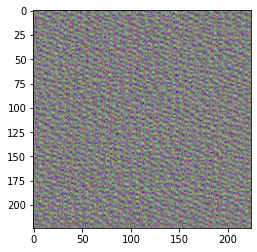

In [ ]:
x = np.random.random((1, 3, 224, 224)) #* 20 + 128
x = torch.tensor(x, dtype=torch.float32, requires_grad=True)

img = generate_pattern(x, model, layer_num=11, filter_index=0, n=150)
plt.imshow(img);

  0%|          | 0/150 [00:00<?, ?it/s]

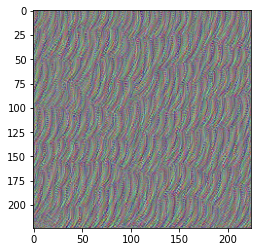

In [ ]:
x = np.random.random((1, 3, 224, 224)) #* 20 + 128
x = torch.tensor(x, dtype=torch.float32, requires_grad=True)

img = generate_pattern(x, model, layer_num=13, filter_index=0, n=150)
plt.imshow(img);

In [ ]:
img.shape

(224, 224, 3)

Похоже данный фильр отвечает за узор в горошек. Чтож, посмотрим чуть более широко. Берем первые 64 фильра первых 4х блоков. Поехали!

In [ ]:
%%time

size = 224
margin = 5
num = 8  # number of filters in a row
for layer_num in [1, 6, 11, 18]:
    # тут будем хранить результаты, пока же блок пустой
    results = np.zeros((num * size + (num-1) * margin, num * size + (num-1) * margin, 3))

    for i in range(num):  # итерируемся по строкам нашего результаты
        for j in range(num):  # итерируемся по столбцам
            
            x = np.random.random((1, 3, size, size)) #* 20 + 128
            x = torch.tensor(x, dtype=torch.float32, requires_grad=True)
            filter_img = generate_pattern(x, model, layer_num=layer_num, 
                                          filter_index=i + (j * 8), n=40)

            # кладем результаты в квадраты
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Визуализация результатов в сетке
    results=results.astype(int)
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

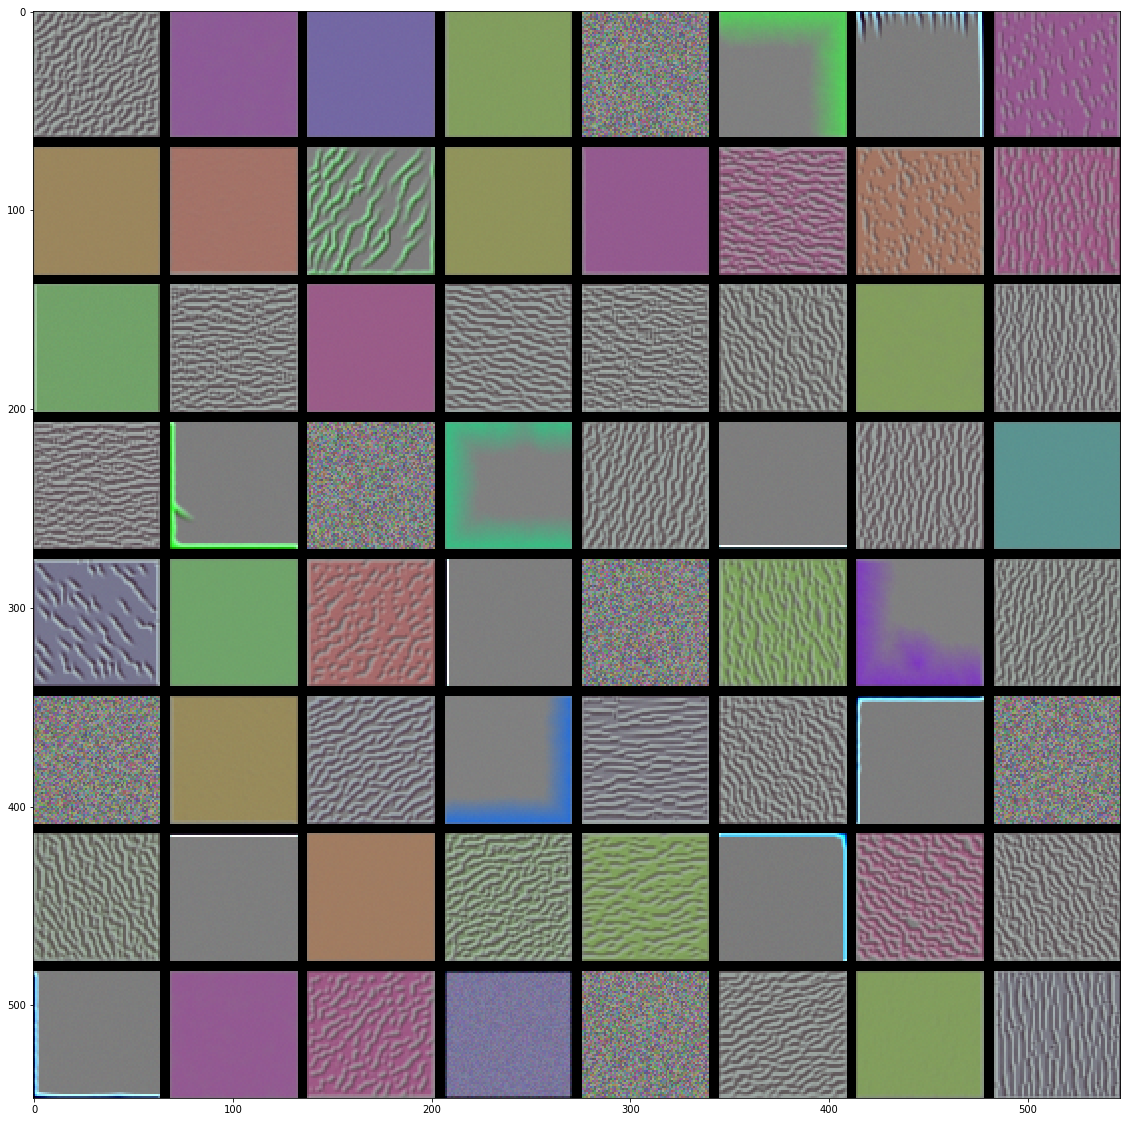

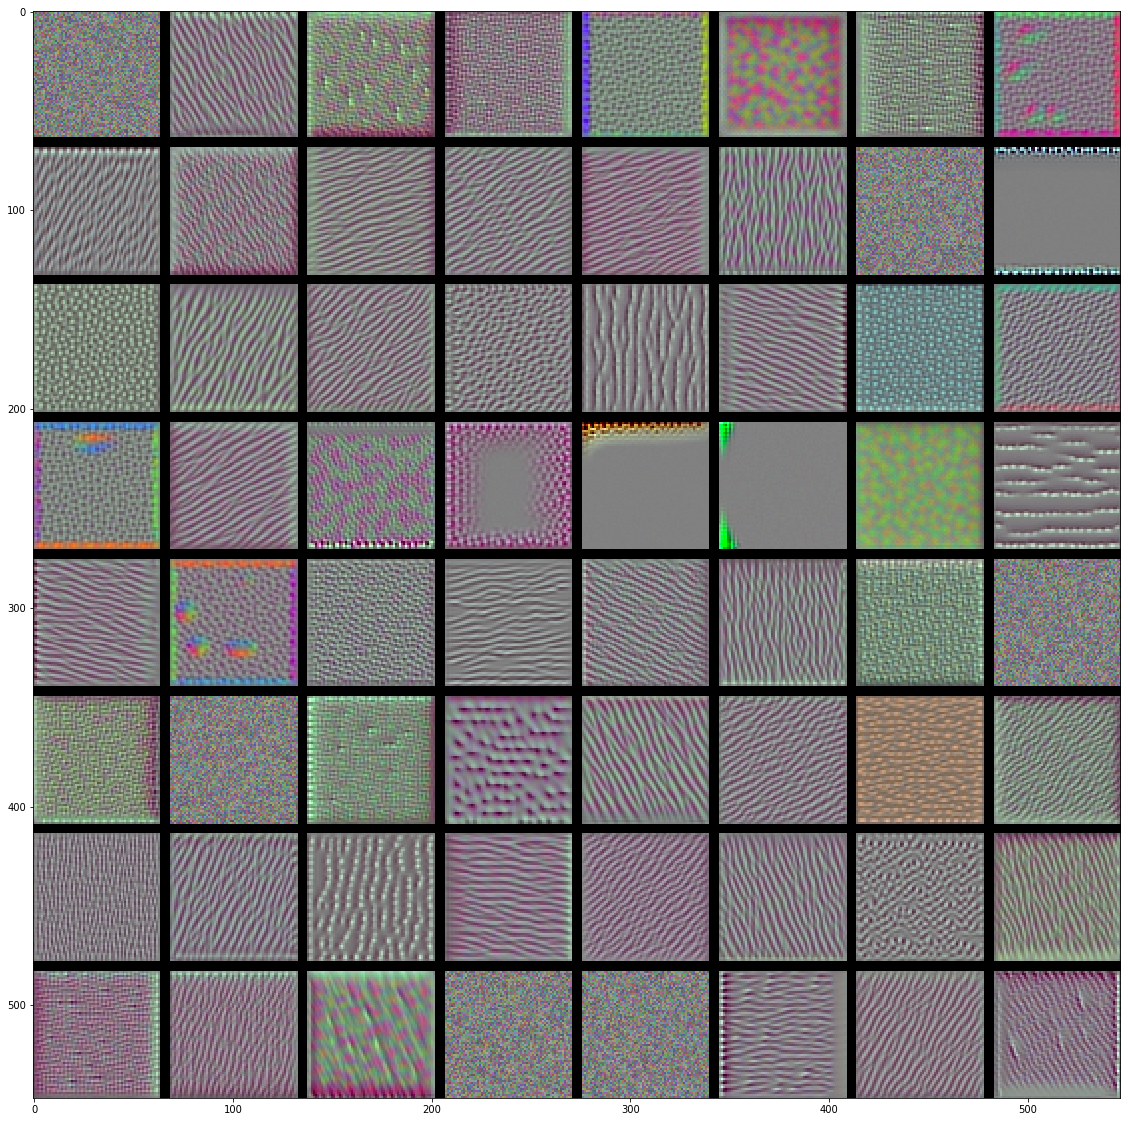

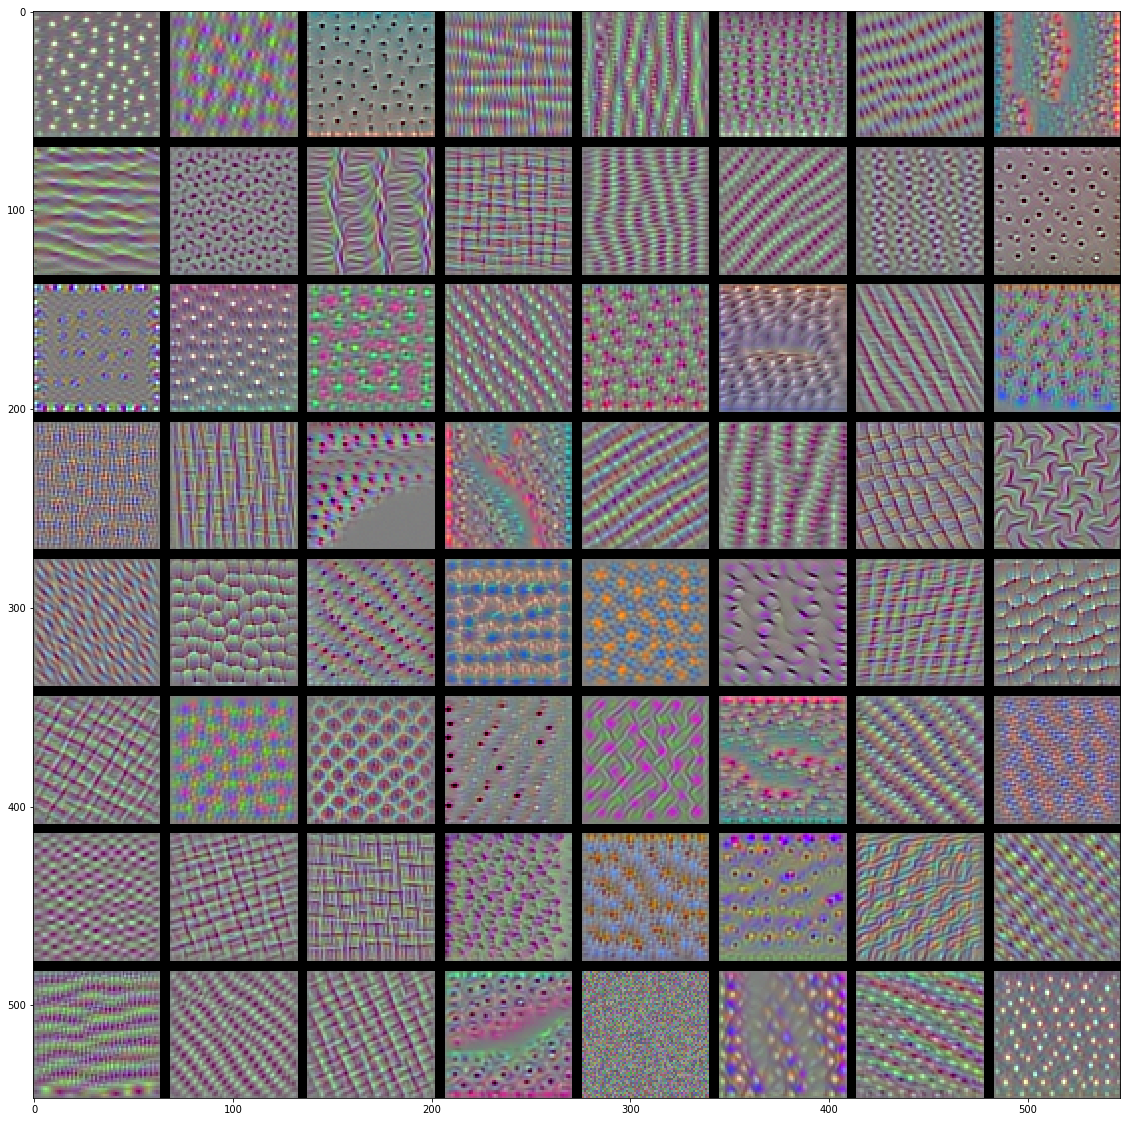

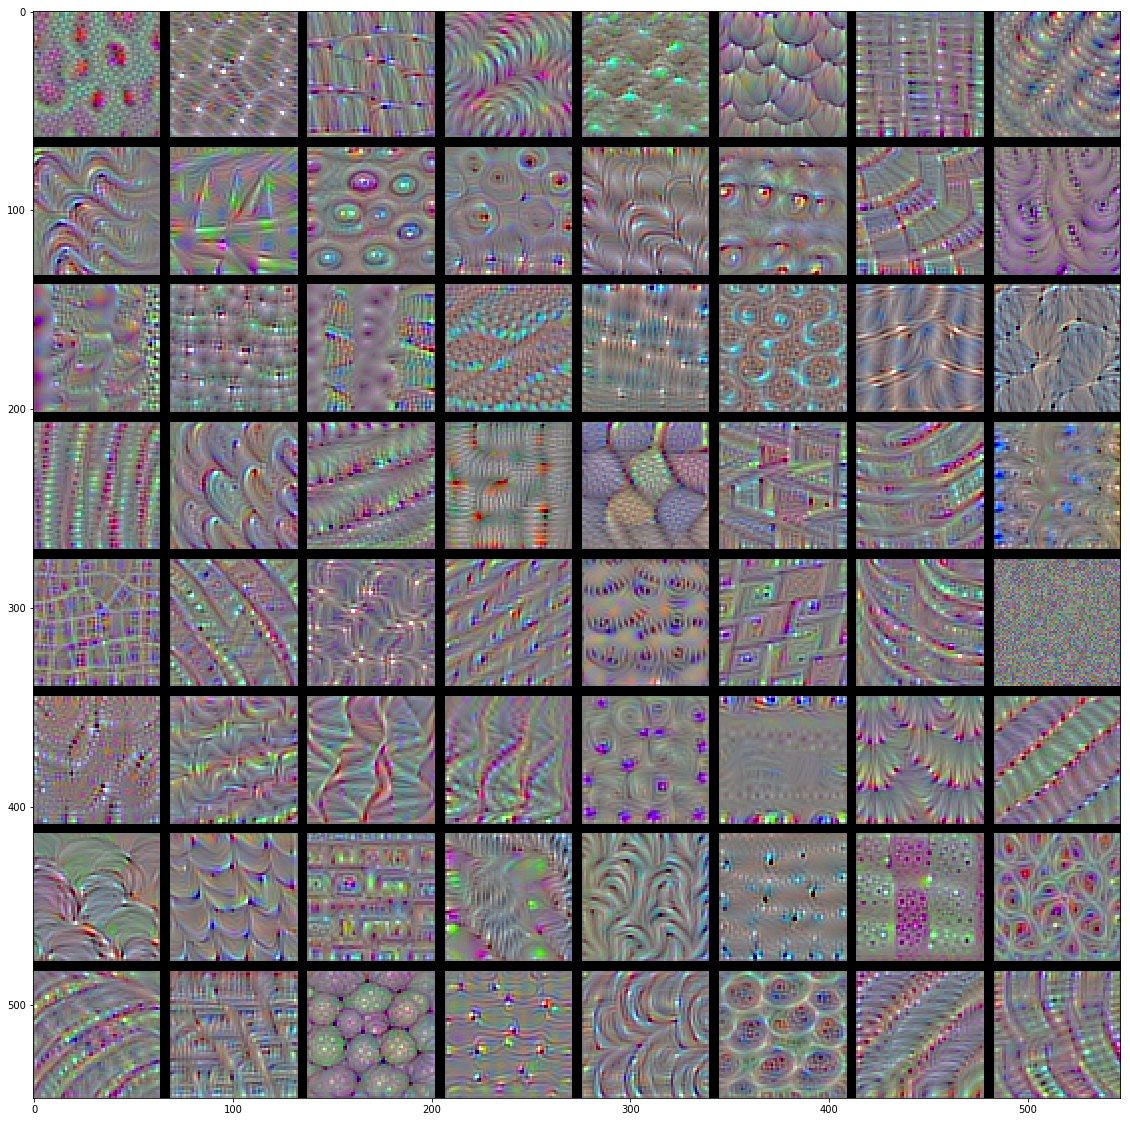

In [ ]:
# for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
#     size = 64
#     margin = 5

#     # тут будем хранить результаты, пока же блок пустой
#     results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

#     for i in range(8):  # итерируемся по строкам нашего результаты
#         for j in range(8):  # итерируемся по столбцам
            
#             filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

#             # кладем результаты в квадраты
#             horizontal_start = i * size + i * margin
#             horizontal_end = horizontal_start + size
#             vertical_start = j * size + j * margin
#             vertical_end = vertical_start + size
#             results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

#     # Визуализация результатов в сетке
#     results=results.astype(int)
#     plt.figure(figsize=(20, 20))
#     plt.imshow(results)
#     plt.show()

Такой подход помогает нам понять, как сетки видят мир. Похоже на разложение Фурье, когда мы рассладываем сигнал на частоты.


* Фильры из первого слоя в модели (`block1_conv1`) кодирует простые направления или цвета (или могут цветные контуры)
* Фильтры `block2_conv1` кодирует простые текстуры, состоящие из комбинации контуров и цветов.
* Фильтры следующего уровня начинают напоминать текстуры в естественном изображении-перья, глаза, листья и т.д.